<a href="https://colab.research.google.com/github/Ashishpathak78/ML_-Practice/blob/Ashish/ML_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Setup & Imports**

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 5.1 MB/s eta 0:00:00


In [ ]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay

# ML models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Advanced ML
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# For hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
import optuna

# Handling imbalance
from imblearn.over_sampling import SMOTE


# **Step 2: Load Dataset**

Shape: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Outcome
0    500
1    268
Name: count, dtype: int64


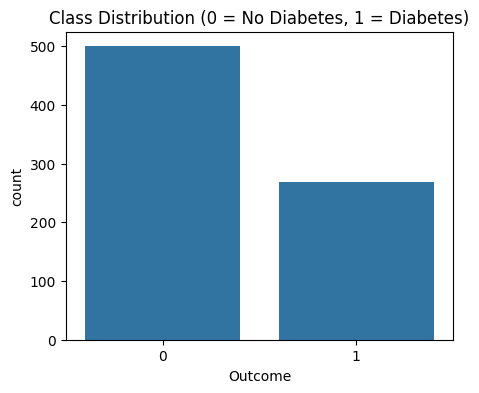

In [ ]:
# Replace with your dataset path
df = pd.read_csv("/content/diabetes.csv")

print("Shape:", df.shape)
print(df.head())

# Check class distribution
print(df['Outcome'].value_counts())

sns.countplot(x='Outcome', data=df)
plt.title("Class Distribution (0 = No Diabetes, 1 = Diabetes)")
plt.show()


# **Step 3: Train-Test Split + Preprocessing**

In [ ]:
plt.rcParams["figure.figsize"] = (5, 4)  # all plots will use this size


In [ ]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Handle imbalance with SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)


# **Step 4: Helper Function for Evaluation**

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
    }
    if y_prob is not None:
        metrics["ROC-AUC"] = roc_auc_score(y_test, y_prob)

    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    if y_prob is not None:
        RocCurveDisplay.from_predictions(y_test, y_prob)
        plt.show()

    return metrics


# **Step 5: Baseline Models**


KNN Results:
              precision    recall  f1-score   support

           0       0.82      0.66      0.73       100
           1       0.54      0.74      0.62        54

    accuracy                           0.69       154
   macro avg       0.68      0.70      0.68       154
weighted avg       0.73      0.69      0.70       154



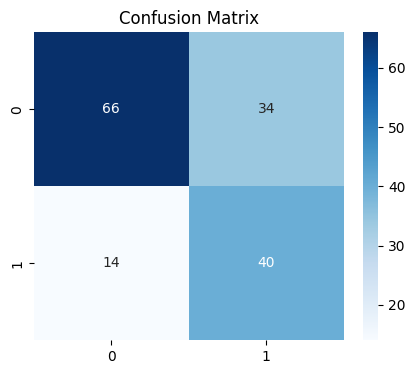

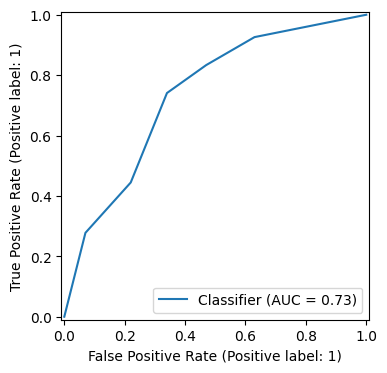


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       100
           1       0.61      0.72      0.66        54

    accuracy                           0.74       154
   macro avg       0.72      0.74      0.73       154
weighted avg       0.75      0.74      0.74       154



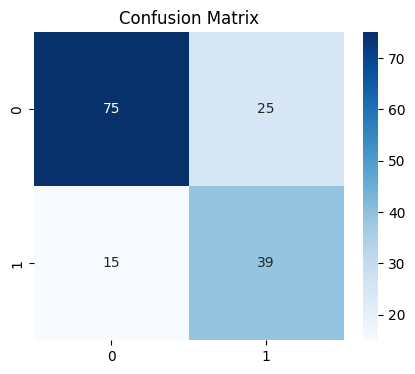

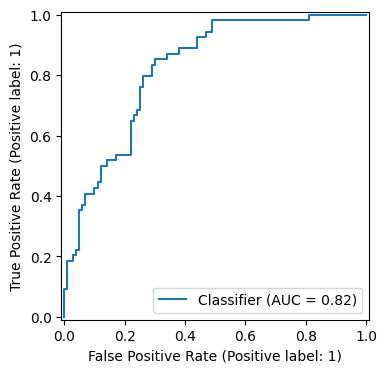


Decision Tree Results:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       100
           1       0.66      0.50      0.57        54

    accuracy                           0.73       154
   macro avg       0.71      0.68      0.69       154
weighted avg       0.73      0.73      0.72       154



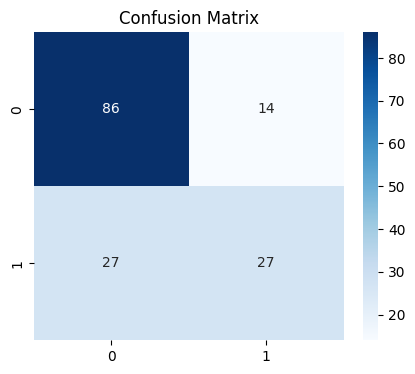

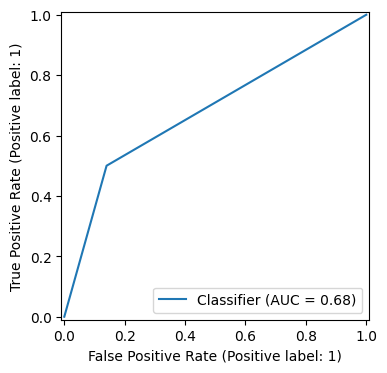


Random Forest Results:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       100
           1       0.63      0.69      0.65        54

    accuracy                           0.75       154
   macro avg       0.72      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154



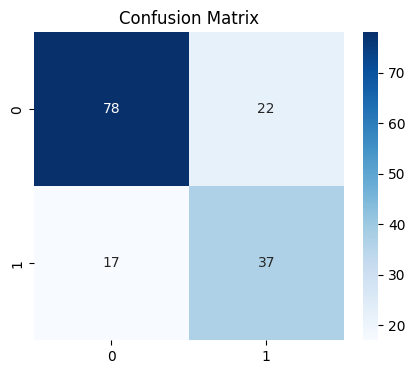

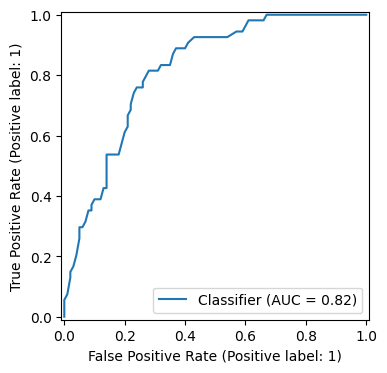


SVM Results:
              precision    recall  f1-score   support

           0       0.84      0.69      0.76       100
           1       0.57      0.76      0.65        54

    accuracy                           0.71       154
   macro avg       0.71      0.72      0.70       154
weighted avg       0.75      0.71      0.72       154



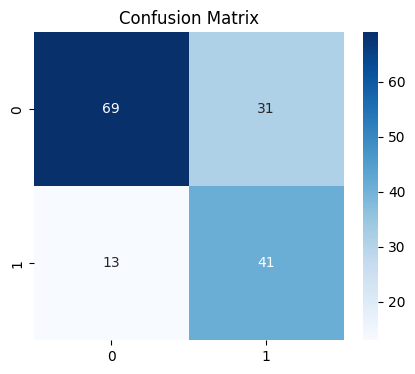

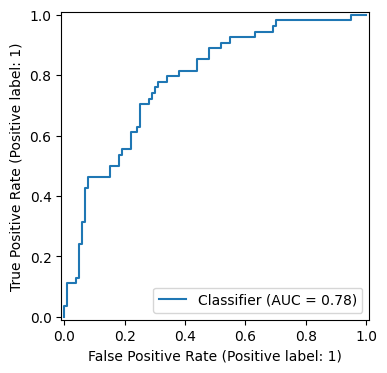

                     Accuracy  Precision    Recall  F1-score   ROC-AUC
KNN                  0.688312   0.540541  0.740741  0.625000  0.734352
Logistic Regression  0.740260   0.609375  0.722222  0.661017  0.822222
Decision Tree        0.733766   0.658537  0.500000  0.568421  0.680000
Random Forest        0.746753   0.627119  0.685185  0.654867  0.817963
SVM                  0.714286   0.569444  0.759259  0.650794  0.782778


In [ ]:
models = {
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\n{name} Results:")
    metrics = evaluate_model(model, X_train_res, y_train_res, X_test, y_test)
    results[name] = metrics

results_df = pd.DataFrame(results).T
print(results_df)


# **Step 6: Hyperparameter Tuning Example (Random Forest)**

Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20}
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       100
           1       0.63      0.74      0.68        54

    accuracy                           0.76       154
   macro avg       0.74      0.76      0.75       154
weighted avg       0.77      0.76      0.76       154



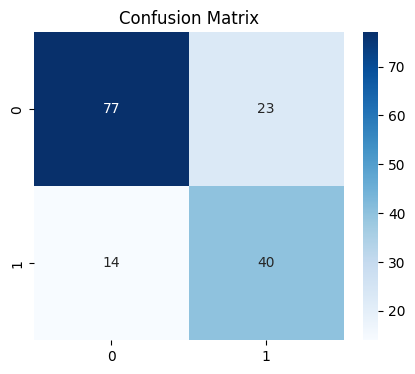

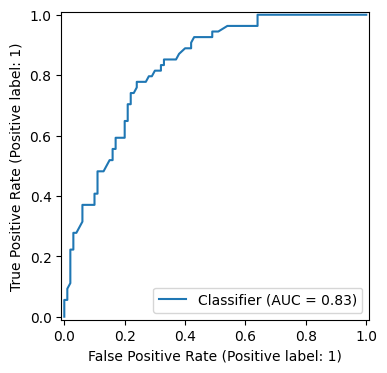

{'Accuracy': 0.7597402597402597, 'Precision': 0.6349206349206349, 'Recall': 0.7407407407407407, 'F1-score': 0.6837606837606838, 'ROC-AUC': np.float64(0.826388888888889)}


In [ ]:
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", "log2"]
}

rf = RandomForestClassifier(random_state=42)
rs = RandomizedSearchCV(rf, param_dist, n_iter=20, cv=5, scoring="f1", n_jobs=-1, random_state=42)
rs.fit(X_train_res, y_train_res)

print("Best Params:", rs.best_params_)
best_rf = rs.best_estimator_

tuned_metrics = evaluate_model(best_rf, X_train_res, y_train_res, X_test, y_test)
print(tuned_metrics)


# **Step 7: Advanced Models (XGBoost, LightGBM)**

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       100
           1       0.65      0.69      0.67        54

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:05:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


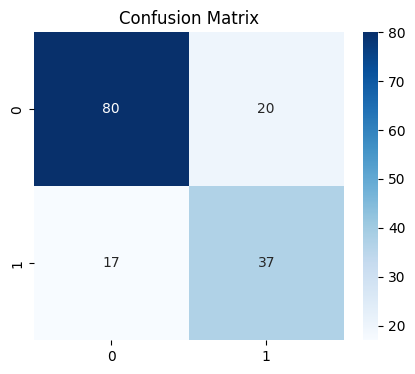

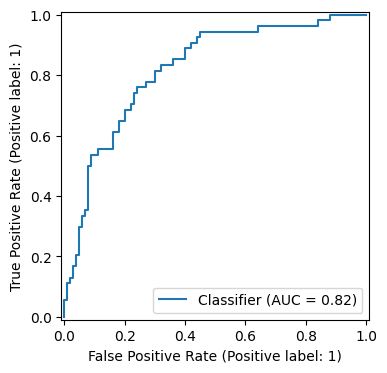

[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 892
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


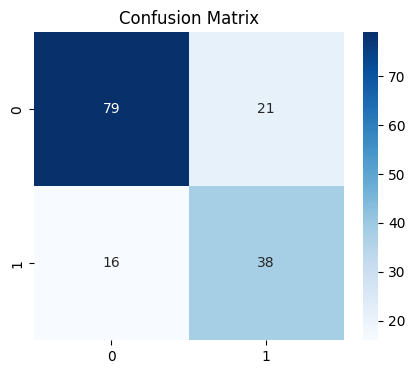

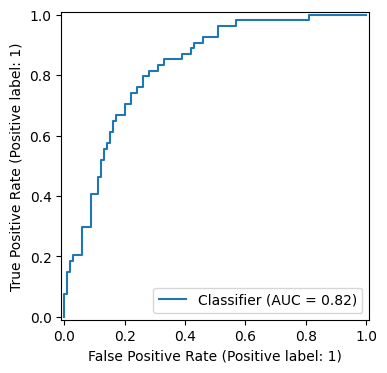

                     Accuracy  Precision    Recall  F1-score   ROC-AUC
KNN                  0.688312   0.540541  0.740741  0.625000  0.734352
Logistic Regression  0.740260   0.609375  0.722222  0.661017  0.822222
Decision Tree        0.733766   0.658537  0.500000  0.568421  0.680000
Random Forest        0.746753   0.627119  0.685185  0.654867  0.817963
SVM                  0.714286   0.569444  0.759259  0.650794  0.782778
XGBoost              0.759740   0.649123  0.685185  0.666667  0.819630
LightGBM             0.759740   0.644068  0.703704  0.672566  0.825000


In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_metrics = evaluate_model(xgb, X_train_res, y_train_res, X_test, y_test)

lgb = LGBMClassifier(random_state=42)
lgb_metrics = evaluate_model(lgb, X_train_res, y_train_res, X_test, y_test)

results["XGBoost"] = xgb_metrics
results["LightGBM"] = lgb_metrics

final_results = pd.DataFrame(results).T
print(final_results)


In [ ]:
final_results.to_csv("results.csv", index=True)